In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import arrow
from pathlib import Path
import netCDF4 as nc
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm as cm

In [22]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
tmask = meshmask.tmask
mbathy = meshmask.mbathy

mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
thalweg_SI = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/SaanichInlet_thalweg.txt' 
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/HoodCanal_thalweg.txt' 
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_ptsSI = np.loadtxt(thalweg_SI, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)
thalweg_ptsSoG = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
depth = mesh.variables['gdept_0'][:]


In [5]:
# Constant and data rang
syear = 2018
eyear = 2018
smonth = 1
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)

2018-01-01T00:00:00+00:00 2018-12-31T00:00:00+00:00


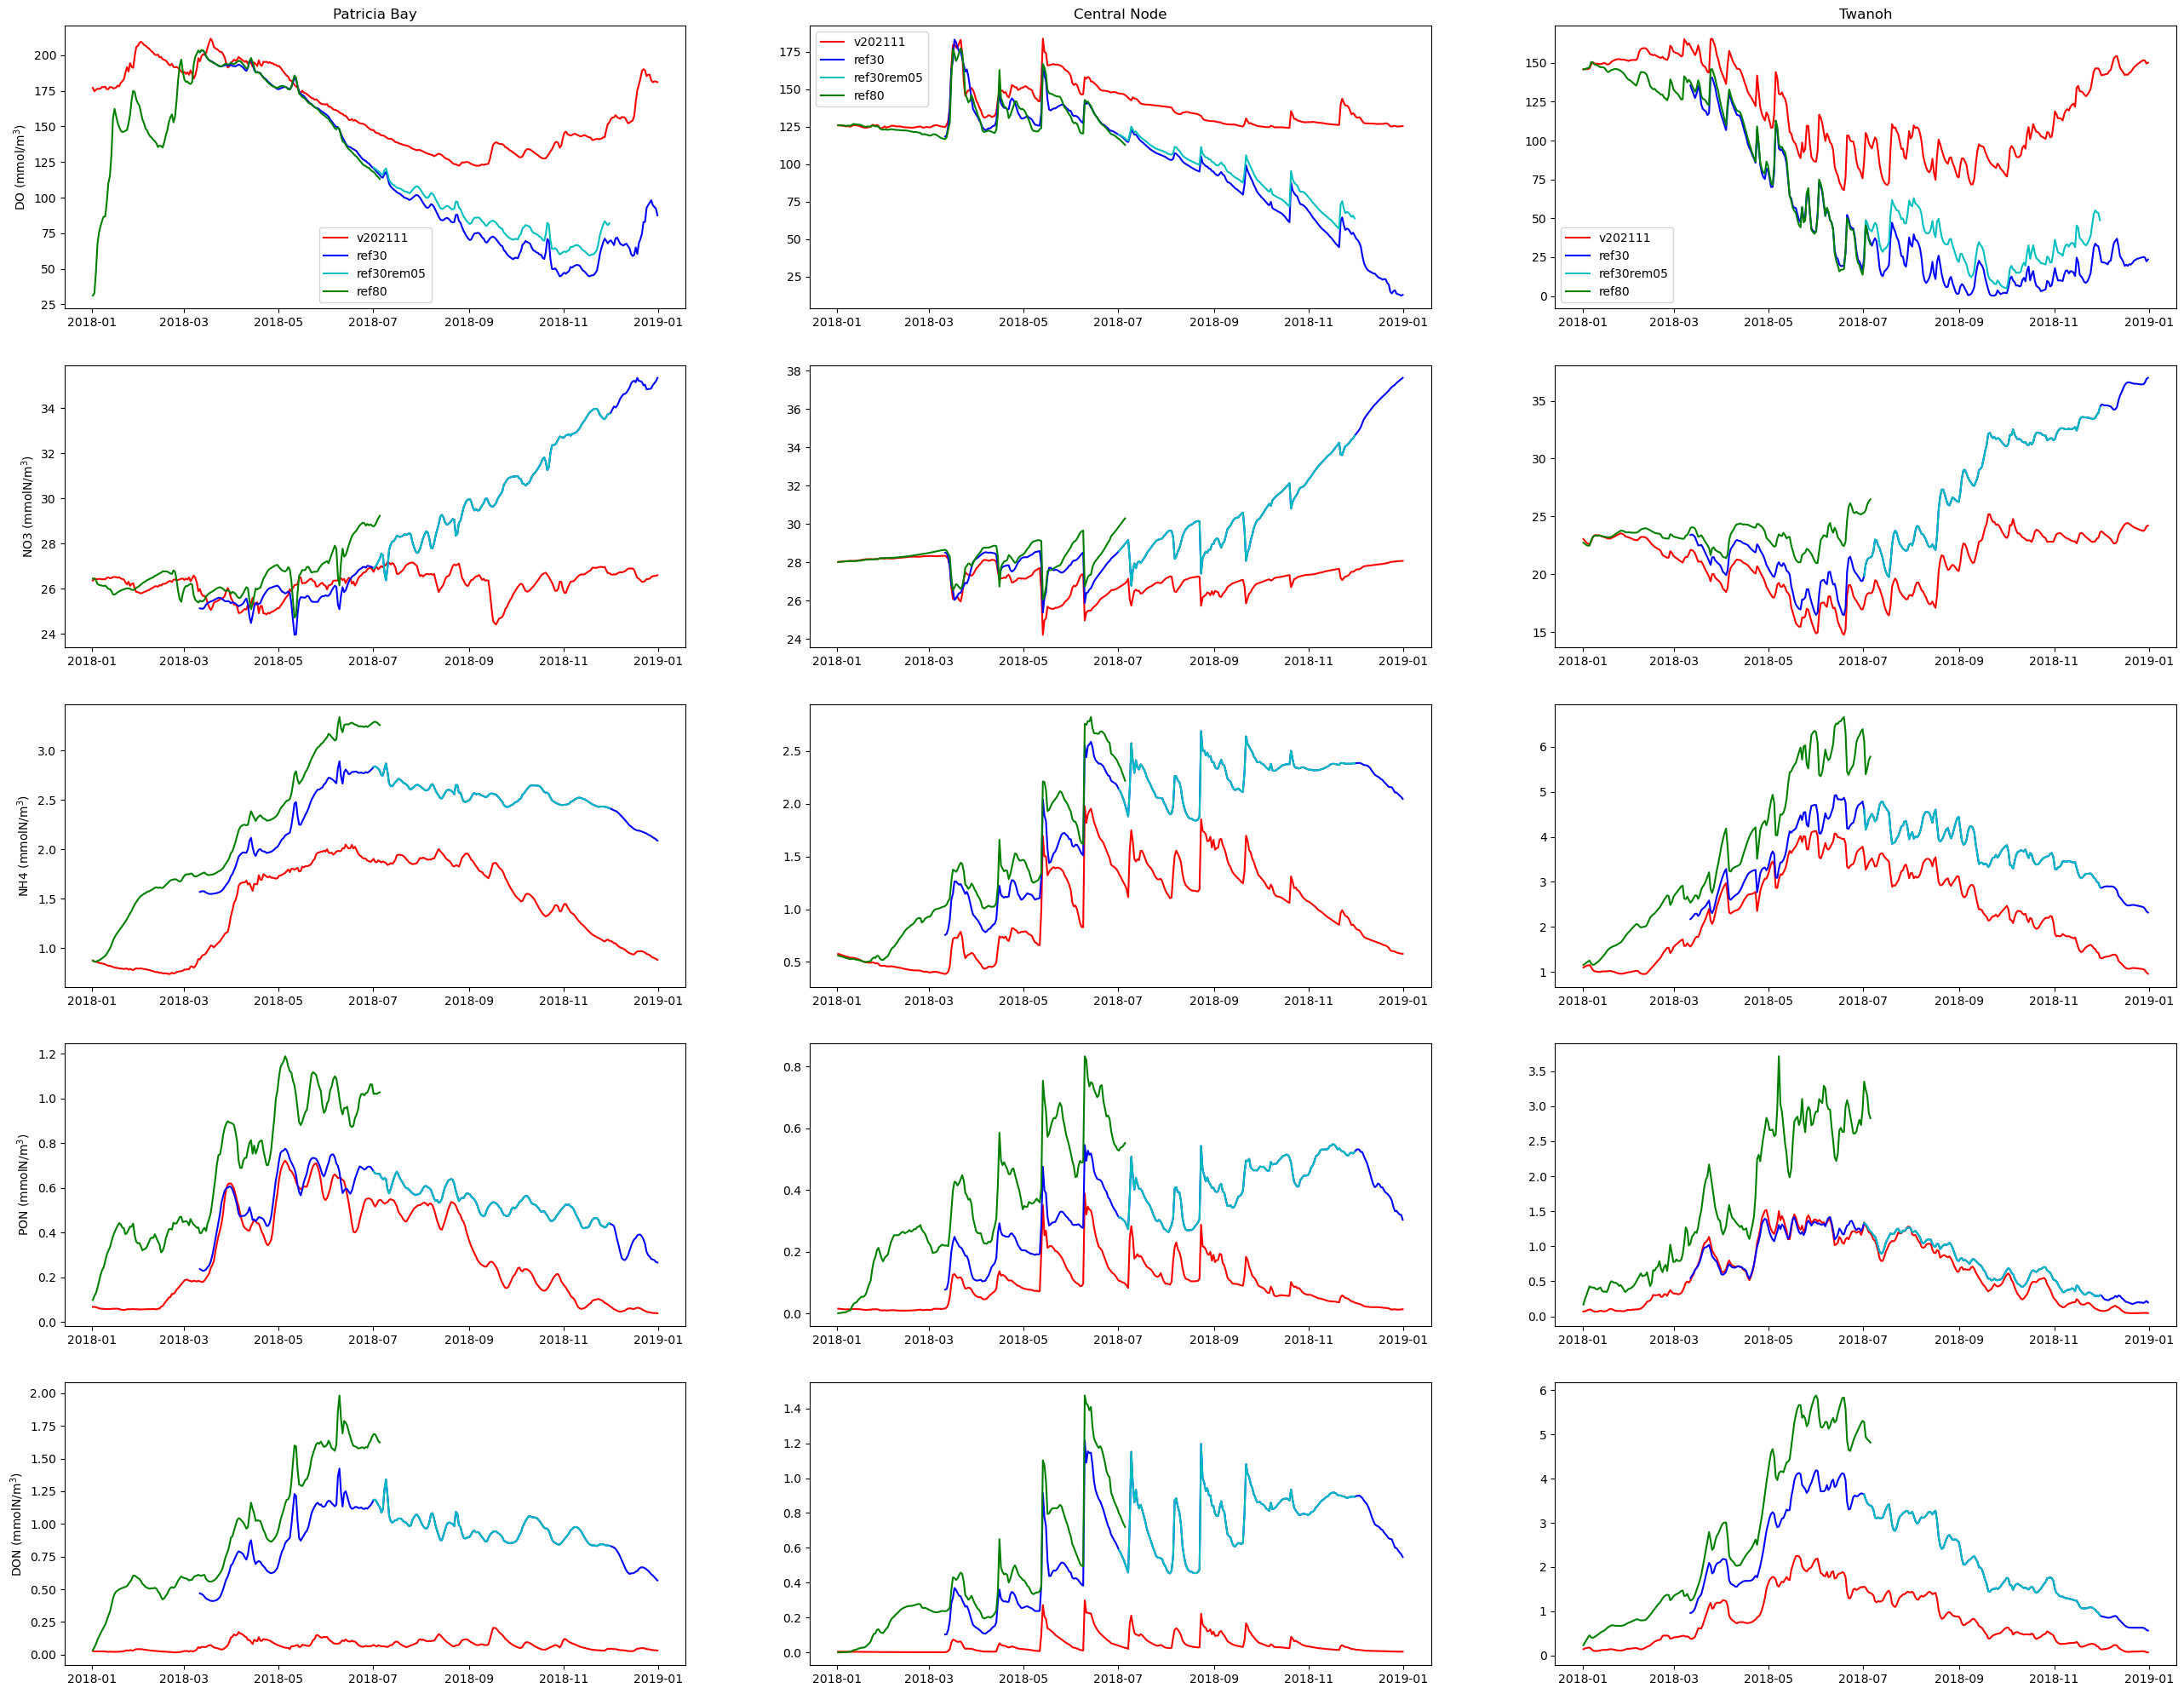

In [6]:
print (startdate, enddate)
line, col = (5, 3)
fig, ax = plt.subplots(line, col, figsize=(32, 25))
ylabel = list(['DO (mmol/m$^3$)','NO3 (mmolN/m$^3$)','NH4 (mmolN/m$^3$)','PON (mmolN/m$^3$)','DON (mmolN/m$^3$)'])
place = list(['Patricia Bay','Central Node','Twanoh'])
for alpha in range(0, 4):
    if alpha == 0:
        dir = '/results2/SalishSea/nowcast-green.202111/'
        colors = 'r'
        labels = 'v202111'
    elif alpha==1:
        dir = '/ocean/sallen/timbucktwo/oxygen_Pref30/'
        colors = 'b'
        labels = 'ref30'
        smonth = 3
        emonth = 12
        startdate = arrow.get(syear, smonth, 11)
        enddate = arrow.get(eyear, emonth, 31)
    elif alpha==2:
        dir = '/ocean/sallen/timbucktwo/oxygen/'
        colors = 'c'
        labels = 'ref30rem05'
        smonth = 7
        emonth = 11
        startdate = arrow.get(syear, smonth, 1)
        enddate = arrow.get(eyear, emonth, 30)
    else:
        dir = '/ocean/sallen/timbucktwo/oxygen_Pref80/'
        colors = 'g'
        labels = 'ref80'
        smonth = 1
        emonth = 7
        startdate = arrow.get(syear, smonth, 1)
        enddate = arrow.get(eyear, emonth, 5)
    for j in range(0, col):
        if j==0:
            jj, ii = (353, 209)
        elif j==1:
            jj, ii = (423, 266)
        else:
            jj, ii = (72, 123)   
        first = True
        for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
            year = day.year
            yr2 = day.strftime("%y")
            month = day.month
            Month = day.strftime("%b").lower()
            day = day.day
            # set up filename to follow NEMO conventions
            fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
            with xr.open_dataset(fchem) as ds_chem:
                oxy0 = ds_chem['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            fbiol = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
            with xr.open_dataset(fbiol) as ds_biol:
                nit0 = ds_biol['nitrate'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                amm0 = ds_biol['ammonium'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                pon0 = ds_biol['particulate_organic_nitrogen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                don0 = ds_biol['dissolved_organic_nitrogen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            if first:
                first = False
                oxy = oxy0
                pon = pon0
                don = don0
                nit = nit0
                amm = amm0
            else:
                oxy = xr.concat([oxy, oxy0], dim='time_counter')
                nit = xr.concat([nit, nit0], dim='time_counter')
                amm = xr.concat([amm, amm0], dim='time_counter')
                pon = xr.concat([pon, pon0], dim='time_counter')
                don = xr.concat([don, don0], dim='time_counter')
        for i  in range(0, line):
            if i==0:
                var = oxy
            elif i==1:
                var = nit
            elif i==2:
                var = amm
            elif i==3:
                var = pon
            elif i==4:
                var = don

            ax[i,j].plot(var.time_counter, var, color=colors, label=labels)
            ax[0,j].legend()
            ax[i,0].set_ylabel(f'{ylabel[i]}')
            ax[0,j].set_title(f'{place[j]}')
            ax[i,j].grid()


# Oxygen diff between zz_alpha_SOD (Bremin) = 50% and 100%

2018-07-01T00:00:00+00:00 2018-12-15T00:00:00+00:00


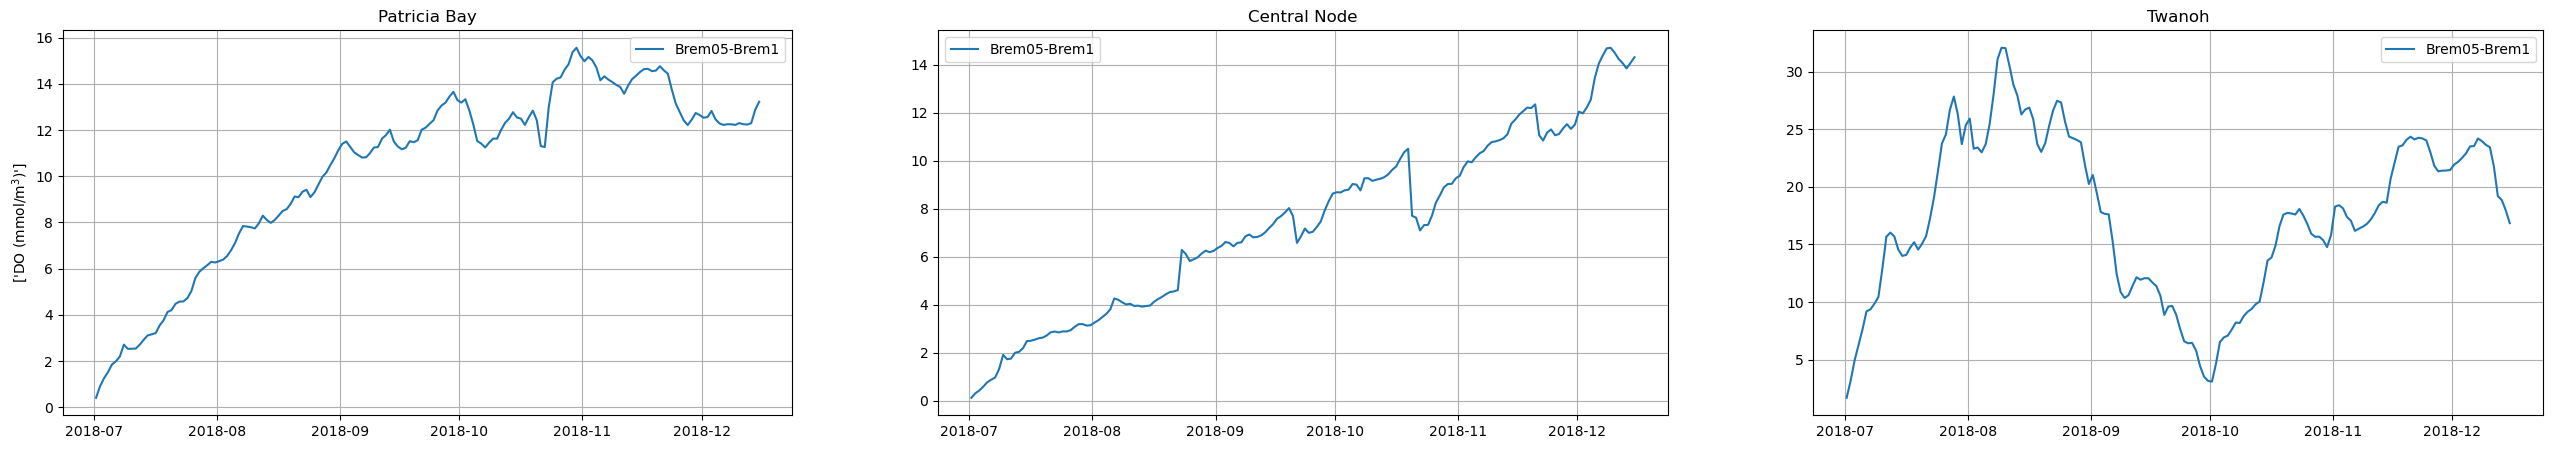

In [23]:
syear = 2018
eyear = 2018
smonth = 7
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 15)
print (startdate, enddate)
line, col = (1, 3)
fig, ax = plt.subplots(line, col, figsize=(32, 5))
ylabel = list(['DO (mmol/m$^3$)'])
place = list(['Patricia Bay','Central Node','Twanoh'])
dir = '/ocean/sallen/timbucktwo/oxygen/'
dir2 = '/ocean/sallen/timbucktwo/oxygen_Pref30/'

for j in range(0, col):
    if j==0:
        jj, ii = (353, 209)
    elif j==1:
        jj, ii = (423, 266)
    else:
        jj, ii = (72, 123)   
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
        fchem2 = f'{dir2}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem2) as ds_chem2:
            oxy02 = ds_chem2['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
        if first:
            first = False
            oxy = oxy0
            oxy2 = oxy02
        else:
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
            oxy2 = xr.concat([oxy2, oxy02], dim='time_counter')

    ax[j].plot(oxy.time_counter, oxy-oxy2, label='Brem05-Brem1')
    ax[0].set_ylabel(f'{ylabel}')
    ax[j].set_title(f'{place[j]}')
    ax[j].grid()
    ax[j].legend()

# Along the thalwegs: Saanich, SoG, Hood Canal

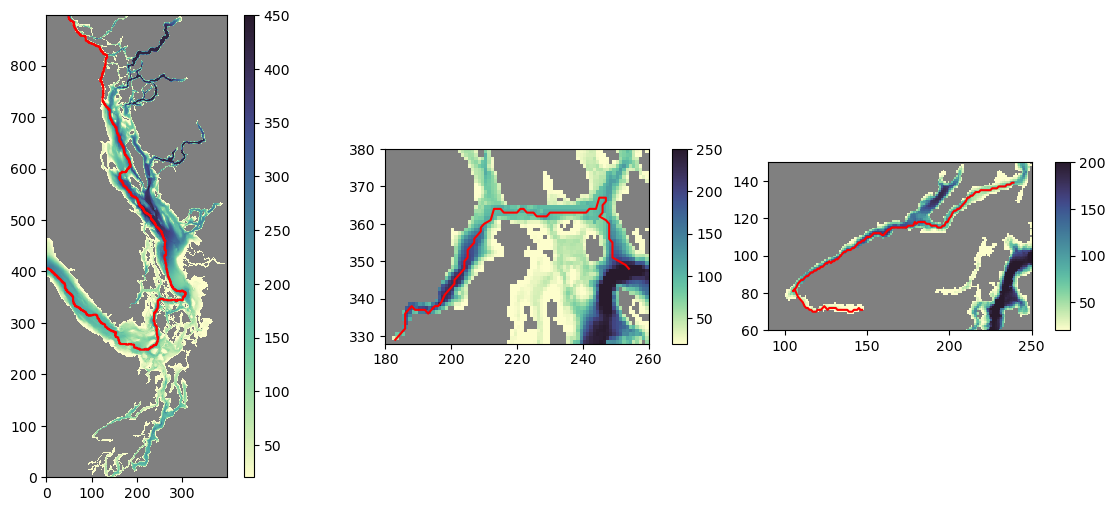

In [16]:
line, col = (1, 3)
fig, ax = plt.subplots(line, col, figsize=(14, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
for ii in range(0, col):
    if ii==0:
        thalweg=thalweg_ptsSoG
        vmin,vmax=(20,450)
    elif ii==1:
        thalweg=thalweg_ptsSI
        ax[ii].set_xlim([180, 260])
        ax[ii].set_ylim([328, 380])
        vmin,vmax=(20,250)
    else:
        thalweg=thalweg_ptsHC
        ax[ii].set_xlim(90,250)
        ax[ii].set_ylim(60,150)
        vmin,vmax=(20,200)

    im = ax[ii].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=vmin, vmax=vmax)
    ax[ii].plot(thalweg[:,1],thalweg[:,0],color='r')
    viz_tools.set_aspect(ax[ii]);
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


Text(0.5, 0.98, '2018-12-14T00:00:00+00:00-2018-12-15T00:00:00+00:00: Brem05-Brem1')

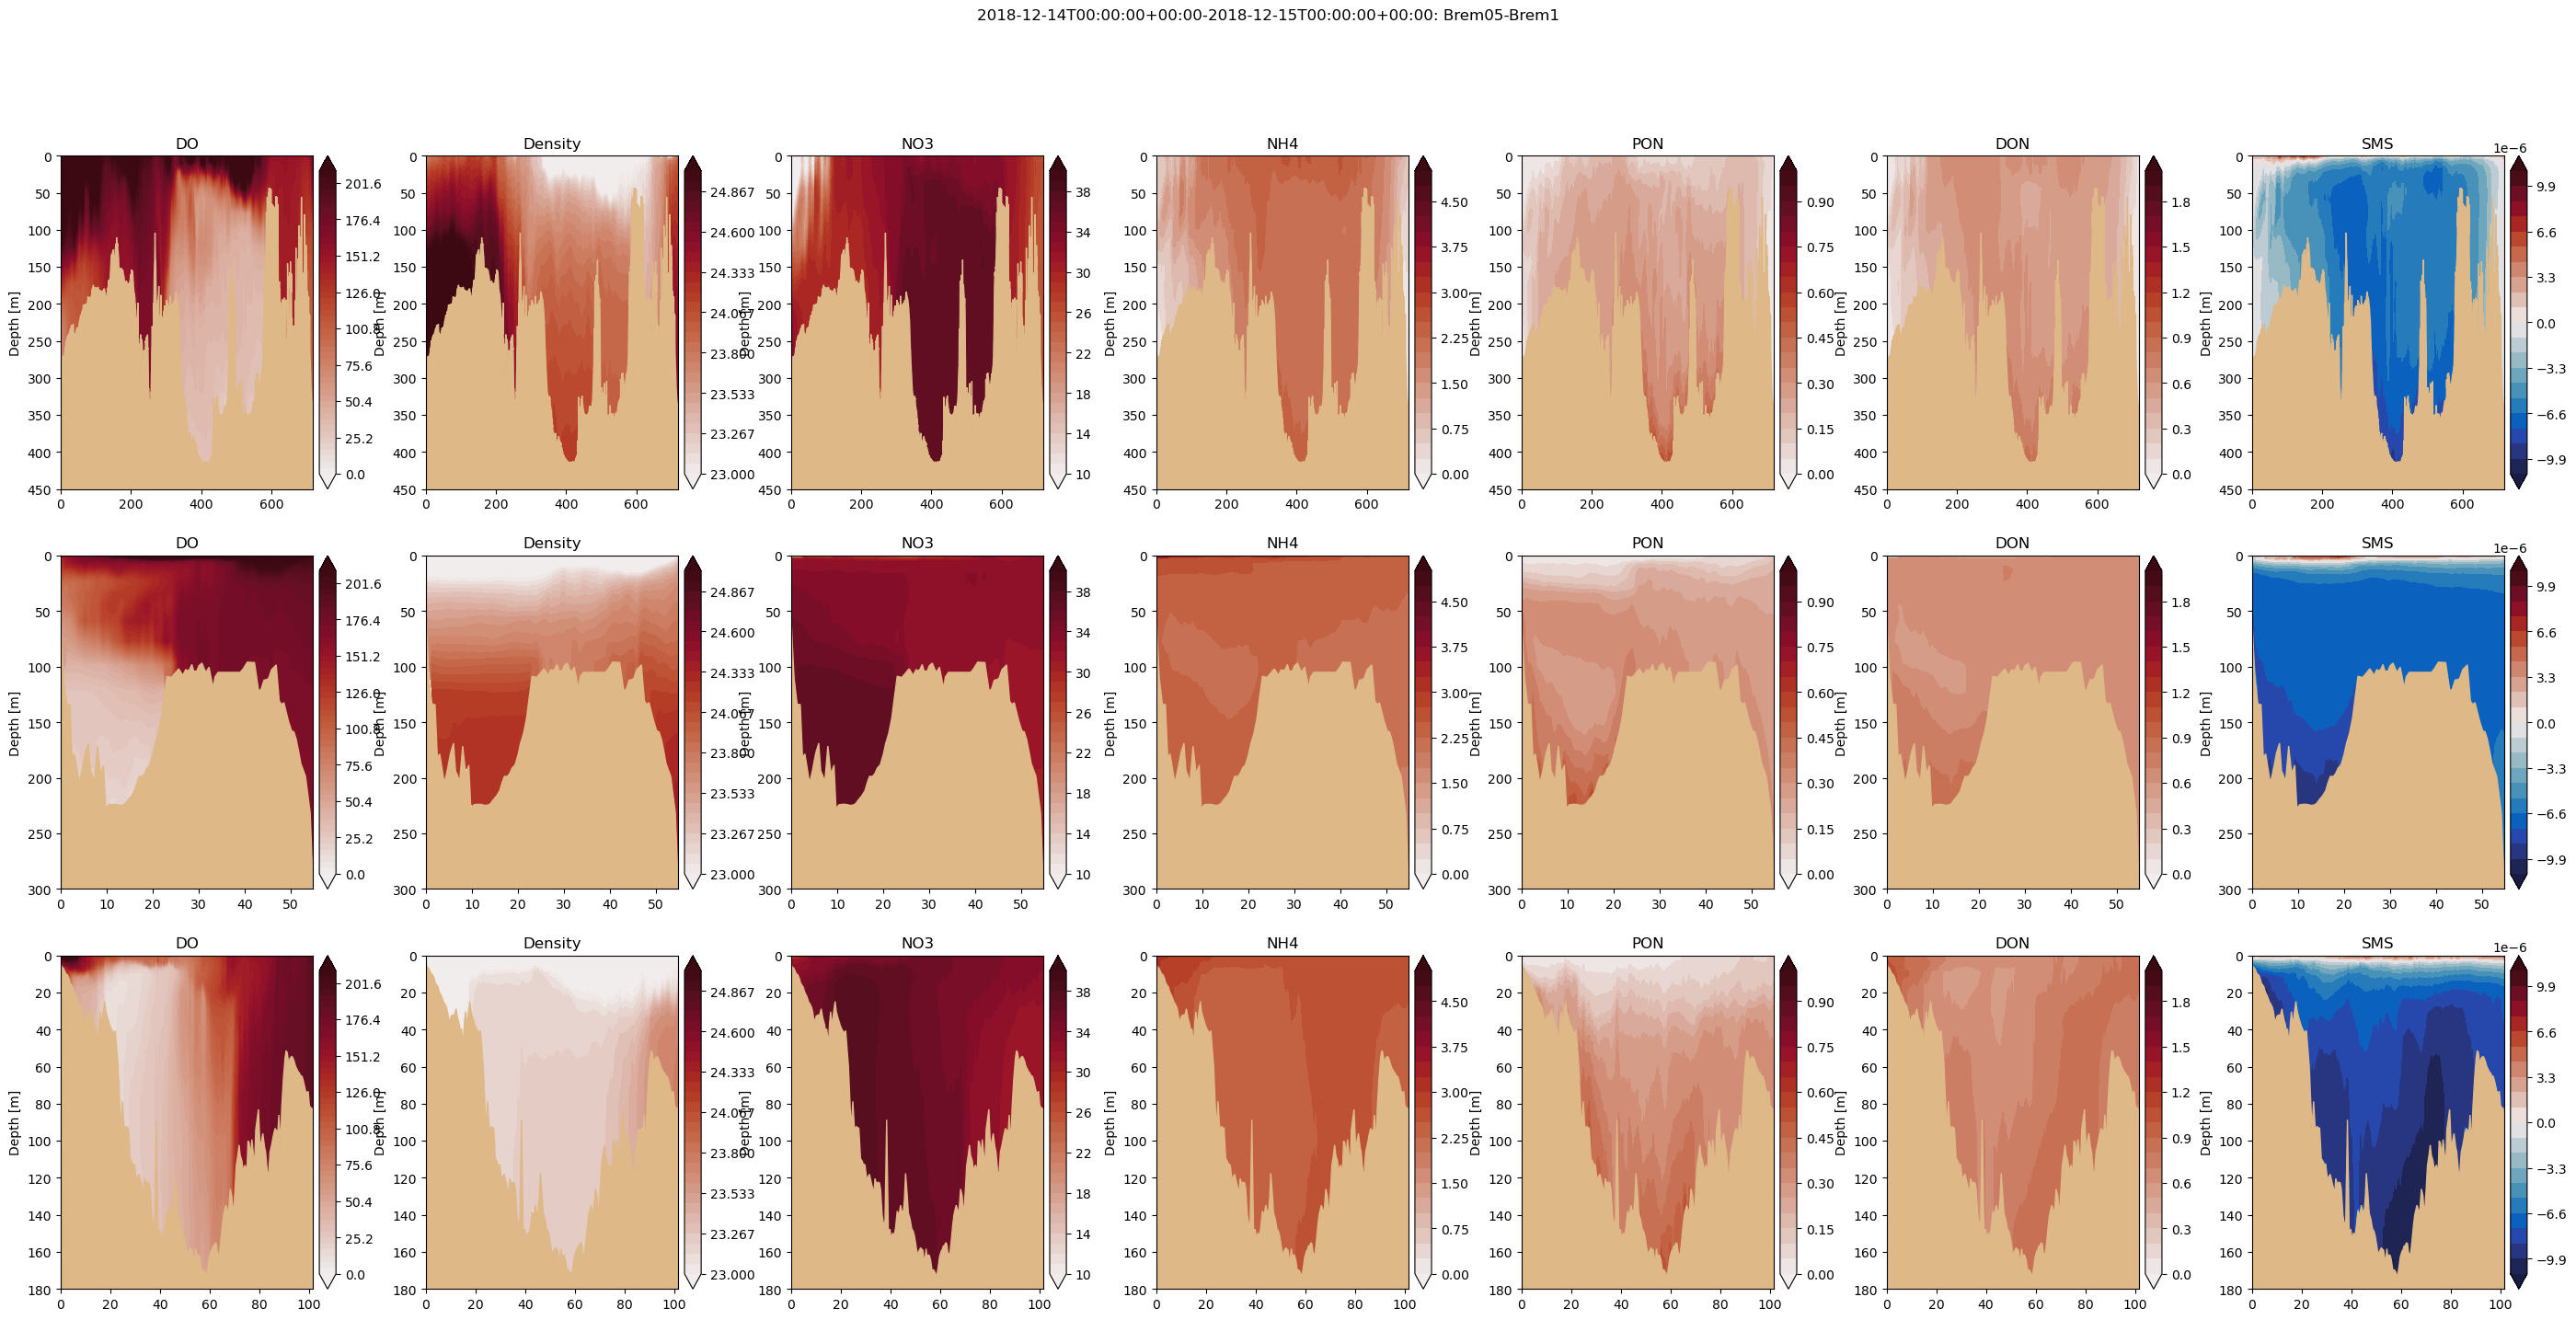

In [27]:
syear = 2018
eyear = 2018
smonth = 12
emonth = 12
startdate = arrow.get(syear, smonth, 14)
enddate = arrow.get(eyear, emonth, 15)
line, col = (3, 7)
fig, axs = plt.subplots(line, col, figsize=(35, 16))
title = list(['DO','Density','NO3','NH4','PON','DON','SMS'])
dir = '/ocean/sallen/timbucktwo/oxygen/'
for ii in range(0, line):
    if ii==0:
        thalweg=thalweg_ptsSoG
        depmin=450
        vmin,vmax=(20,450)
    elif ii==1:
        thalweg=thalweg_ptsSI[::-1]
        depmin=300
        vmin,vmax=(20,250)
    else:
        thalweg=thalweg_ptsHC
        depmin=180
        vmin,vmax=(20,200)
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen']
        fbiol = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
        with xr.open_dataset(fbiol) as ds_biol:
            nit0 = ds_biol['nitrate']
            amm0 = ds_biol['ammonium']
            pon0 = ds_biol['particulate_organic_nitrogen']
            don0 = ds_biol['dissolved_organic_nitrogen']
        fgrdT = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
        with xr.open_dataset(fgrdT) as ds_grdT:
            den0 = ds_grdT['sigma_theta']
        fdiag = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc'
        with xr.open_dataset(fdiag) as ds_diag:
            npp0 = ds_diag['NPP']
            rpp0 = ds_diag['RPP']
            rem0 = ds_diag['RMIN']
            ntr0 = ds_diag['NITR']
            mes0 = ds_diag['RMES']
            mic0 = ds_diag['RMIC']
        if first:
            first = False
            oxy = oxy0
            pon = pon0
            don = don0
            nit = nit0
            amm = amm0
            den = den0
            npp = npp0
            rpp = rpp0
            rem = rem0
            ntr = ntr0
            mes = mes0
            mic = mic0
        else:
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
            nit = xr.concat([nit, nit0], dim='time_counter')
            amm = xr.concat([amm, amm0], dim='time_counter')
            pon = xr.concat([pon, pon0], dim='time_counter')
            don = xr.concat([don, don0], dim='time_counter')
            den = xr.concat([den, den0], dim='time_counter')
            npp = xr.concat([npp, npp0], dim='time_counter')
            rpp = xr.concat([rpp, rpp0], dim='time_counter')
            rem = xr.concat([rem, rem0], dim='time_counter')
            nrt = xr.concat([ntr, ntr0], dim='time_counter')
            mes = xr.concat([mes, mes0], dim='time_counter')
            mic = xr.concat([mic, mic0], dim='time_counter')
    
    for jj  in range(0, col):
        cmap = cm.amp
        if jj==0:
            vars = oxy
            space = np.linspace(0, 210, 51)
        elif jj==1:
            vars=den
            space = np.linspace(23, 25, 31)
        elif jj==2:
            vars=nit
            space = np.linspace(10, 40, 31)
        elif jj==3:
            vars=amm
            space = np.linspace(0, 5, 21)
        elif jj==4:
            vars=pon
            space = np.linspace(0, 1, 21)
        elif jj==5:
            vars=don
            space = np.linspace(0, 2, 21)
        else:
            vars= npp + rpp + rem + ntr + mes + mic
            space = np.linspace(-0.000011, 0.000011, 21)
            cmap = cm.balance

        dep_thal, distance, var_thal = vis.load_thalweg(
            depth[0, ...], np.array(vars).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],
                thalweg)
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg)
        colours_var = axs[ii,jj].contourf(distance, dep_thal, var_plot, space,
                                            cmap=cmap, extend='both')
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalweg, axs[ii,jj], color='burlywood')
        axs[ii,jj].invert_yaxis()
        axs[ii,jj].set_ylabel('Depth [m]');
        axs[ii,jj].set_ylim([depmin, 0])
        axs[ii,jj].set_title(f'{title[jj]}')
        cbar = fig.colorbar(colours_var, ax=axs[ii,jj], pad=0.02)
    
fig.suptitle(f'{startdate}-{enddate}: Brem05-Brem1')

